<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/ner_tagging/NER%20tagging%20with%20BiLSTM%20CRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NER Dataset

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ravirajag","key":"7c9b32c3baf1bd5e404db6e4e281fc5c"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

 34% 9.00M/26.4M [00:00<00:00, 18.6MB/s]
100% 26.4M/26.4M [00:00<00:00, 45.1MB/s]


In [5]:
!unzip entity-annotated-corpus.zip

Archive:  entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


### Imports

In [6]:
import os
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from itertools import chain
from collections import Counter
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Exploration

In [8]:
datafile = 'ner_dataset.csv'

In [9]:
df = pd.read_csv(datafile, encoding="latin1", error_bad_lines=False)
df = df.fillna(method='ffill')

In [10]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [11]:
len(df)

1048575

In [12]:
tags = list(df.Tag.unique())
tags

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

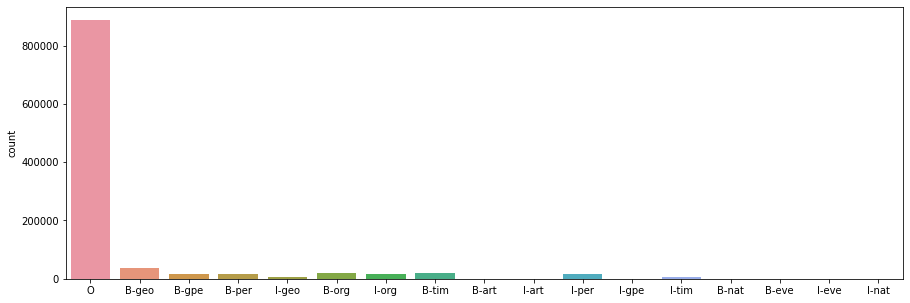

In [13]:
plt.figure(figsize=(15, 5))
sns.countplot(df.Tag.values)

In [14]:
num_tags = len(tags)
num_tags

17

### Sentences

In [15]:
agg_func = lambda s: [(w, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
group = df.groupby("Sentence #").apply(agg_func)
lines = [s for s in group]

In [16]:
lines[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [17]:
sentences = [['<START>'] + [tokens[0] for tokens in line] + ['<END'] for line in lines]
tags = [['<START>'] + [tokens[1] for tokens in line] + ['<END'] for line in lines]

In [18]:
len(sentences), len(tags)

(47959, 47959)

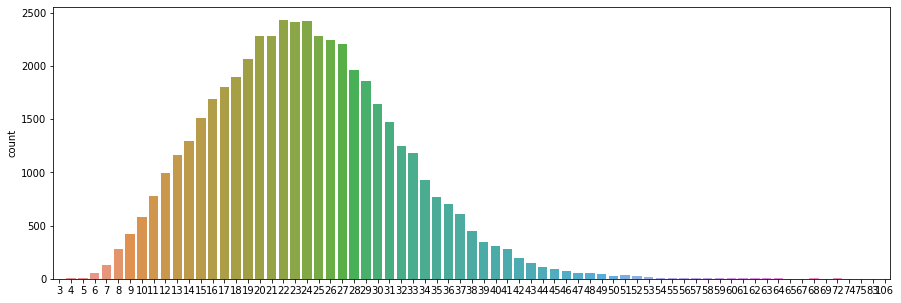

In [19]:
sen_lengths = [len(sent) for sent in sentences]
plt.figure(figsize=(15, 5))
sns.countplot(sen_lengths)

In [20]:
train_sentences, valid_sentences, train_tags, valid_tags = train_test_split(sentences, tags, test_size=0.2, random_state=42)
valid_sentences, test_sentences, valid_tags, test_tags = train_test_split(valid_sentences, valid_tags, test_size=0.5, random_state=42)
len(train_sentences), len(valid_sentences), len(test_sentences)

(38367, 4796, 4796)

### Vocabulary

In [21]:
class Vocab:
    def __init__(self, word2id, id2word):
        self.UNK = '<UNK>'
        self.PAD = '<PAD>'
        self.START = '<START>'
        self.END = '<END>'
        self.__word2id = word2id
        self.__id2word = id2word

    def get_word2id(self):
        return self.__word2id

    def get_id2word(self):
        return self.__id2word

    def __getitem__(self, item):
        if self.UNK in self.__word2id:
            return self.__word2id.get(item, self.__word2id[self.UNK])
        return self.__word2id[item]

    def __len__(self):
        return len(self.__word2id)

    def id2word(self, idx):
        return self.__id2word[idx]

In [22]:
def build_vocab(data, freq_cutoff=5, is_tags=False):
    word_counts = Counter(chain(*data))
    valid_words = [w for w, d in word_counts.items() if d >= freq_cutoff]
    valid_words = sorted(valid_words, key=lambda x: word_counts[x], reverse=True)
    valid_words += ['<PAD>']
    word2id = {w: idx for idx, w in enumerate(valid_words)}
    if not is_tags:
        word2id['<UNK>'] = len(word2id)
        valid_words += ['<UNK>']
    return Vocab(word2id=word2id, id2word=valid_words)

In [23]:
words_vocab = build_vocab(train_sentences)
tags_vocab = build_vocab(train_tags)

### NER Dataset 

In [24]:
MAX_SEN_LEN = 50

In [25]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, tags, max_len):
        self.sentences = sentences
        self.tags = tags
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        tag = self.tags[item]
        tokens, tags = [], []

        for word, t in zip(sentence, tag):
            tokens.append(words_vocab[word])
            tags.append(tags_vocab[t])

        return torch.LongTensor(tokens), torch.LongTensor(tags)

In [26]:
train_dataset = NERDataset(train_sentences, train_tags, MAX_SEN_LEN)
valid_dataset = NERDataset(valid_sentences, valid_tags, MAX_SEN_LEN)
test_dataset = NERDataset(test_sentences, test_tags, MAX_SEN_LEN)

In [27]:
train_dataset[0]

(tensor([   1,  150,  235,   11,   36,   72,   49, 3318,    8, 1977, 4171,  166,
         9619, 9619, 7832,    4,  199,    7, 1385, 9619,   67, 1103,    3,    2]),
 tensor([ 1,  3, 10,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  2]))

### DataLoaders

In [28]:
BATCH_SIZE = 128

In [29]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, tags = zip(*data)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
    labels = torch.zeros(len(sentences), max(sent_lengths)).long()
    
    for i, (sent, lab) in enumerate(zip(sentences, tags)):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i, :end] = lab[:end]

    return inputs, labels, sent_lengths


In [30]:
train_data_loader = data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [31]:
sample = next(iter(train_data_loader))

In [32]:
sample[0].shape, sample[1].shape, len(sample[2])

(torch.Size([128, 59]), torch.Size([128, 59]), 128)

### BiLSTM-CRF Model

In [79]:
class BiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, tag_vocab_size, sent_pad_token, tag_start_token, dropout=0.3):
        super().__init__()
        self.hid_dim = hid_dim
        self.sent_pad_token = sent_pad_token
        self.tag_start_token = tag_start_token
        self.tag_vocab_size = tag_vocab_size

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            emb_dim,
            hid_dim,
            bidirectional=True,
            batch_first=True
        )
        self.emission = nn.Linear(hid_dim * 2, tag_vocab_size)
        self.transition = nn.Parameter(torch.rand(tag_vocab_size, tag_vocab_size))

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, sentences, lengths, tags):
        # sentences => [batch_size, seq_len]
        # lengths => [batch_size]
        # tags => [batch_size, seq_len]

        mask = (sentences != self.sent_pad_token).to(device)
        # mask => [batch_size, seq_len]

        embed = self.embedding(sentences)
        embed = self.dropout(embed)
        # embed => [batch_size, seq_len, emb_dim]

        packed_inp = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True)
        packed_output, _ = self.lstm(packed_inp)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # outputs => [batch_size, seq_len, hid_dim * 2]

        combined = torch.cat((outputs[:, :, :self.hid_dim], outputs[:, :, self.hid_dim:]), dim=-1)
        combined = self.dropout(combined)
        # combined => [batch_size, seq_len, hid_dim * 2]

        emission_scores = self.emission(combined)
        # emission_scores => [batch_size, seq_len, tag_size]

        loss = self.vitebri_loss(tags, mask, emission_scores)
        # loss => [batch_size]

        return loss

    def vitebri_loss(self, tags, mask, emit_scores):
        # tags => [batch_size, seq_len]
        # mask => [batch_size, seq_len]
        # emit_scores => [batch_size, seq_len, tag_size]

        batch_size, sent_len = tags.shape

        # calculate the ground truth score
        score = torch.gather(emit_scores, 2, tags.unsqueeze(2)).squeeze(2)
        # emission scores of actual tags
        # score => [batch_size, seq_len]

        # add the transition scores to the emission scores
        # ignore the start token tag score
        score[:, 1:] += self.transition[tags[:, :-1], tags[:, 1:]]

        # consider only the scores of actual tokens not the padded
        gold_scores = (score * mask.type(torch.float)).sum(dim=1)
        # gold_scores => [batch_size]

        # calculate the scores of the partition (Z)
        # tensor to hold the accumulated sequence scores at each time step
        # at the inital time step score will be on dim=0
        scores_upto_t = emit_scores[:, 0].unsqueeze(1)
        # scores_upto_t => [batch_size, 1, tag_size]

        for i in range(1, sent_len):
            # get the current batch_size
            batch_t = mask[:, i].sum()

            # get the accumulated scores till now (only the current batch size)
            scores_unpad = scores_upto_t[:batch_t]
            # scores_unpad => [batch_t, 1, tag_size]

            # add the transition scores for this time step
            scores_with_trans = emit_scores[:batch_t, i].unsqueeze(1) + self.transition
            # scores_with_trans => [batch_t, tag_size, tag_size]

            # add to the accumulation
            sum_scores = scores_unpad.transpose(1, 2) + scores_with_trans
            # sum_scores => [batch_t, tag_size, tag_size]
            
            # apply the following to overcome the overflow problems
            # since the exp(some_big_number) will cause issues 
            # log(Σ exp(z_k)) = max(z) + log(Σ exp(z_k - max(z)))
            # log(Σ exp(z_k)) = log(Σ exp(z_k - c + c))
            #                 = log(Σ exp(z_k - c) * exp(c))
            #                 = log(Σ exp(z_k - c)) + log(exp(c))
            #                 = log(Σ exp(z_k - c)) + c
            # by taking c as max(z)
            # log(Σ exp(z_k)) = max(z) + log(Σ exp(z_k - max(z))) [log_sum_exp]
            # get the maximum score of the current time step
            max_t = sum_scores.max(dim=1)[0].unsqueeze(1)
            # max_t => [batch_t, 1, tag_size]

            sum_scores = sum_scores - max_t
            # sum_scores => [batch_t, tag_size, tag_size]

            scores_t = max_t + torch.logsumexp(sum_scores, dim=1).unsqueeze(1)
            # scores_t => [batch_t, 1, tag_size]

            # update the accumulation scores
            scores_upto_t = torch.cat((scores_t, scores_upto_t[batch_t:]), dim=0)
            # scores_upto_t => [batch_size, 1, tag_size]
        
        final_scores = scores_upto_t.squeeze(1)
        # final_scores => [batch_size, tag_size]

        max_final_scores = final_scores.max(dim=-1)[0]
        # max_final_scores => [batch_size]

        predicted_scores = max_final_scores + torch.logsumexp(final_scores - max_final_scores.unsqueeze(1), dim=1)
        # predicted_scores => [batch_size]

        vitebri_loss = predicted_scores - gold_scores
        # vitebri_loss => [batch_size]

        return vitebri_loss
    
    def predict(self, sentences, lengths):
        # sentences => [batch_size, seq_len]
        # lengths => [batch_size]

        batch_size = sentences.size(0)
        mask = (sentences != self.sent_pad_token).to(device)
        # mask => [batch_size, seq_len]

        embed = self.embedding(sentences)
        embed = self.dropout(embed)
        # embed => [batch_size, seq_len, emb_dim]

        packed_inp = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True)
        packed_output, _ = self.lstm(packed_inp)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # outputs => [batch_size, seq_len, hid_dim * 2]

        combined = torch.cat((outputs[:, :, :self.hid_dim], outputs[:, :, self.hid_dim:]), dim=-1)
        combined = self.dropout(combined)
        # combined => [batch_size, seq_len, hid_dim * 2]

        emission_scores = self.emission(combined)
        # emission_scores => [batch_size, seq_len, tag_size]

        # to store the tags predicted at each time step
        # since at the begining every tag is start tag create the list with start tags
        tags = [[[self.tag_start_token] for _ in range(self.tag_vocab_size)]] * batch_size
        # tags => [batch_size, tag_size, 1]

        scores_upto_t = emission_scores[:, 0].unsqueeze(1)
        # scores_upto_t => [batch_size, 1, tag_size]

        for i in range(1, max(lengths)):
            # get the current batch_size
            batch_t = mask[:, i].sum()

            # get the accumulated scores till now (only the current batch size)
            scores_unpad = scores_upto_t[:batch_t]
            # scores_unpad => [batch_t, 1, tag_size]

            # add the transition scores for this time step
            scores_with_trans = emission_scores[:batch_t, i].unsqueeze(1) + self.transition
            # scores_with_trans => [batch_t, tag_size, tag_size]

            # add to the accumulation
            sum_scores = scores_unpad.transpose(1, 2) + scores_with_trans
            # sum_scores => [batch_t, tag_size, tag_size]

            max_scores_t, max_ids_t = torch.max(sum_scores, dim=1)
            max_ids_t = max_ids_t.tolist()
            # max_scores_t => [batch_t, tag_size]
            # max_ids_t => [batch_t, tag_size]

            # add the current time step predicted tags 
            tags[:batch_t] = [[tags[b][k] + [j] for j, k in enumerate(max_ids_t[b])] for b in range(batch_t)]
            
            # update the accumulation scores
            scores_upto_t = torch.cat((max_scores_t.unsqueeze(1), scores_upto_t[batch_t:]), dim=0)
            # scores_upto_t => [batch_size, tag_size]

        scores = scores_upto_t.squeeze(1)
        # scores => [batch_size, tag_size]

        _, max_ids = torch.max(scores, dim=1)
        max_ids = max_ids.tolist()
        # max_ids => [batch_size]

        # tags => [batch_size, tag_size, seq_len]
        tags = [tags[b][k] for b, k in enumerate(max_ids)]
        # tags => [batch_size, seq_len]

        return tags



In [80]:
vocab_size = len(words_vocab)
sent_pad_token = words_vocab[words_vocab.PAD]
tag_start_token = tags_vocab[tags_vocab.START]
emb_dim = 50
hid_dim = 100
tag_vocab_size = len(tags_vocab)
model = BiLSTMCRF(vocab_size, emb_dim, hid_dim, tag_vocab_size, sent_pad_token, tag_start_token)
model.to(device)

BiLSTMCRF(
  (embedding): Embedding(9620, 50, padding_idx=0)
  (lstm): LSTM(50, 100, batch_first=True, bidirectional=True)
  (emission): Linear(in_features=200, out_features=21, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 607,262 trainable parameters


### Optimizer

In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Training Method

In [37]:
def train(model, iterator, optimizer, clip):
    model.train()

    epoch_loss = 0
    total_sentences = 0

    for batch in iterator:
        sentences = batch[0].to(device)
        tags = batch[1].to(device)
        seq_lengths = batch[2]
        # sentences => [batch_size, seq_len]
        # tags => [batch_size, seq_len]

        optimizer.zero_grad()

        batch_loss = model(sentences, seq_lengths, tags)
        # batch_loss => [batch_size]

        loss = batch_loss.mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += batch_loss.sum().item()
        total_sentences += len(sentences)

    return epoch_loss / total_sentences


### Evaluation Method

In [38]:
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    total_sentences = 0

    with torch.no_grad():
        for batch in iterator:
            sentences = batch[0].to(device)
            tags = batch[1].to(device)
            seq_lengths = batch[2]
            # sentences => [batch_size, seq_len]
            # tags => [batch_size, seq_len]

            batch_loss = model(sentences, seq_lengths, tags)
            # batch_loss => [batch_size]

            loss = batch_loss.mean()

            epoch_loss += batch_loss.sum().item()
            total_sentences += len(sentences)
        
    return epoch_loss / total_sentences


### Training

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [40]:
N_EPOCHS = 10
CLIP = 2
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_data_loader, optimizer, CLIP)
    valid_loss = evaluate(model, valid_data_loader)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 18s
	Train Loss: 15.869 | Val. Loss: 2.219
Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 2.285 | Val. Loss: 1.898
Epoch: 03 | Epoch Time: 0m 18s
	Train Loss: 1.951 | Val. Loss: 1.775
Epoch: 04 | Epoch Time: 0m 18s
	Train Loss: 1.796 | Val. Loss: 1.757
Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 1.703 | Val. Loss: 1.684
Epoch: 06 | Epoch Time: 0m 17s
	Train Loss: 1.639 | Val. Loss: 1.681
Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 1.570 | Val. Loss: 1.686
Epoch: 08 | Epoch Time: 0m 17s
	Train Loss: 1.537 | Val. Loss: 1.657
Epoch: 09 | Epoch Time: 0m 17s
	Train Loss: 1.499 | Val. Loss: 1.666
Epoch: 10 | Epoch Time: 0m 18s
	Train Loss: 1.476 | Val. Loss: 1.667


### Testing

In [83]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [42]:
test_loss = evaluate(model, test_data_loader)
print(f'Test Loss: {test_loss:.3f}')

Test Loss: 1.635


### Inference

In [84]:
def inference(sentence):
    if isinstance(sentence, str):
        tokens = [words_vocab[words_vocab.START]] + sentence.split() + [words_vocab[words_vocab.END]]
    else:
        tokens = sentence
    
    # numericalize
    token_ids = [words_vocab[tok] for tok in tokens]
    
    # seq length
    sent_length = [len(token_ids)]

    # create tensors
    sent_tensor = torch.LongTensor(token_ids).to(device)
    sent_tensor = sent_tensor.unsqueeze(0)
    # sent_tensor => [1, seq_len]

    model.eval()
    with torch.no_grad():
        predictions = model.predict(sent_tensor, sent_length)
    
    predictions = predictions[0]
    predicted_tags = []
    for i in predictions:
        predicted_tags.append(tags_vocab.id2word(i))
    
    return tokens, predicted_tags


In [85]:
sentence = test_sentences[0]
actual_tags = test_tags[0]
tokens, predicted_tag_ids = inference(sentence)

print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, predicted_tag_ids, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")


Pred. Tag	Actual Tag	Correct?	Token

<START>		<START>		✔		<START>
O		O		✔		The
O		O		✔		office
O		O		✔		of
O		O		✔		the
B-gpe		B-gpe		✔		Israeli
O		O		✔		prime
O		O		✔		minister
O		O		✔		says
O		O		✔		a
O		O		✔		visit
O		O		✔		to
B-geo		B-geo		✔		Israel
O		O		✔		by
O		O		✔		the
O		O		✔		foreign
O		O		✔		ministers
O		O		✔		of
B-geo		B-gpe		✘		Egypt
O		O		✔		and
B-gpe		B-gpe		✔		Jordan
O		O		✔		will
O		O		✔		take
O		O		✔		place
B-tim		B-tim		✔		July
I-tim		I-tim		✔		25
O		O		✔		,
O		O		✔		not
O		O		✔		this
O		O		✔		week
O		O		✔		as
O		O		✔		previously
O		O		✔		planned
O		O		✔		.
<END		<END		✔		<END
